In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")    # because pcolormesh doesn't like being given cell centres instead of vertices

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define projection to be used for all maps
cproj = cartopy.crs.epsg(3347)  # native EPSG of homogenous fire regions
cproj.bounds = (3393069.0021458385, 9436930.849558635, 750000, 4340847.387925235)      # modify bounds to focus on region of interest

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Method to reproject lat/lon onto Lambert coordinates
def latlon_to_lambert(da):
    
    # convert dataArray to dataframe
    df = da.to_dataframe().reset_index()
    
    # convert to geoDataFrame, reproject points to Statistics Canada Lambert 
    gdf = gpd.GeoDataFrame(df[df.columns[-1]], geometry = gpd.points_from_xy(df.longitude, df.latitude))
    gdf = gdf.set_crs(epsg = 4326).to_crs(epsg = 3347)
    
    x = np.reshape(np.array(gdf.geometry.x), da.shape)
    y = np.reshape(np.array(gdf.geometry.y), da.shape)
    
    return x,y

---
# **Spatial patterns**

## **Temperature**

In [121]:
varnm = "tas"
sf_ejb = gpd.read_file("sf_ejb").to_crs(cproj)

highresmip_fl = sorted(glob.glob("data/spatial/sp-"+varnm+"_*highresSST*"))
cmip6_fl = sorted(glob.glob("data/spatial/sp-"+varnm+"_day*hist*"))
cordex_fl = sorted(glob.glob("data/spatial/sp-"+varnm+"_NAM-22_*"))

era5 = decode_times(xr.open_dataset("data/spatial/era5_t2m_daily_-145--50E_40-80N.62f4b5a82fde776a4c64f0ca33646aa0.info_12_mean_1.nc", decode_times = False)).t2m
era5 = era5.groupby("time.month").mean("time")
era5 = convert_units_to(era5.sel(month = [6,7,8]).mean("month"), "degC")

def overlay_details(ax):
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))

#================================================================================================================================================

fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (26,10), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.18, hspace = 0.02)
plot_kwargs = {"cmap" : "RdBu_r", "vmin" : -20, "vmax" : 20}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ERA5
x,y = latlon_to_lambert(era5.rename(lon = "longitude", lat = "latitude"))
axs[0,0].pcolormesh(x,y,era5, **plot_kwargs)
axs[0,0].set_title("ERA5")
overlay_details(axs[0,0])

axs[0,1].set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# highresmip
for i in range(len(highresmip_fl)):
    ax = axs[0,i+2]
    fnm = highresmip_fl[i]
    da = xr.open_dataset(fnm)[varnm]
    da = convert_units_to(da.sel(month = [6,7,8]).mean("month"), "degC")
    x,y = latlon_to_lambert(da.rename(lon = "longitude", lat = "latitude"))
    ax.pcolormesh(x,y,da, **plot_kwargs)
    ax.set_title(fnm.split("_")[2]+" "+fnm.split("_")[4])
    overlay_details(ax)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CMIP6
for i in range(len(cmip6_fl)):
    ax = axs[1,i]
    fnm = cmip6_fl[i]
    da = xr.open_dataset(fnm)[varnm]
    da = convert_units_to(da.sel(month = [6,7,8]).mean("month"), "degC")
    x,y = latlon_to_lambert(da.rename(lon = "longitude", lat = "latitude"))
    ax.pcolormesh(x,y,da, **plot_kwargs)
    ax.set_title(fnm.split("_")[2])
    overlay_details(ax)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# regional models
for i in range(len(cordex_fl)):
    ax = axs[2,i]
    fnm = cordex_fl[i]
    da = xr.open_dataset(fnm)[varnm]
    x,y = latlon_to_lambert(da.rename(lon = "longitude", lat = "latitude"))
    ax.pcolormesh(x,y,da, **plot_kwargs)
    ax.set_title(fnm.split("_")[2]+" REMO2015")
    overlay_details(ax)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
axs[2,3].set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
axs[2,4].set_title("CanESM2-CanRCM4")
lens = xr.open_dataset("data/spatial/sp-tas_NAM-44_CCCma-CanESM2_CCCma-CanRCM4_r2.nc").tas.mean("time")
x,y = latlon_to_lambert(lens.rename(lon = "longitude", lat = "latitude"))
axs[2,4].pcolormesh(x,y,lens, **plot_kwargs)
axs[2,4].set_title("CanESM2-CanRCM4")
overlay_details(axs[2,4])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
axs[2,5].set_title("CRCM5")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.suptitle("Spatial pattern of JJA temperature in ERA5 & models", fontweight = "bold", y = 0.9)
plt.savefig("fig/spatial-pattern-tas.png")

## **Precipitation**

In [4]:
varnm = "pr"
sf_ejb = gpd.read_file("sf_ejb").to_crs(cproj)

highresmip_fl = sorted(glob.glob("data/spatial/sp-"+varnm+"_*highresSST*"))
cmip6_fl = sorted(glob.glob("data/spatial/sp-"+varnm+"_day*hist*"))
cordex_fl = sorted(glob.glob("data/spatial/sp-"+varnm+"_NAM-22_*"))

era5 = decode_times(xr.open_dataset("data/spatial/era5_tp_daily_-145--50E_40-80N.62f4b5a82fde776a4c64f0ca33646aa0.info_12_mean_1.nc", decode_times = False)).tp
era5 = era5.groupby("time.month").mean("time")
era5 = era5.sel(month = [3,4,5,6,7]).mean("month")

def overlay_details(ax):
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))

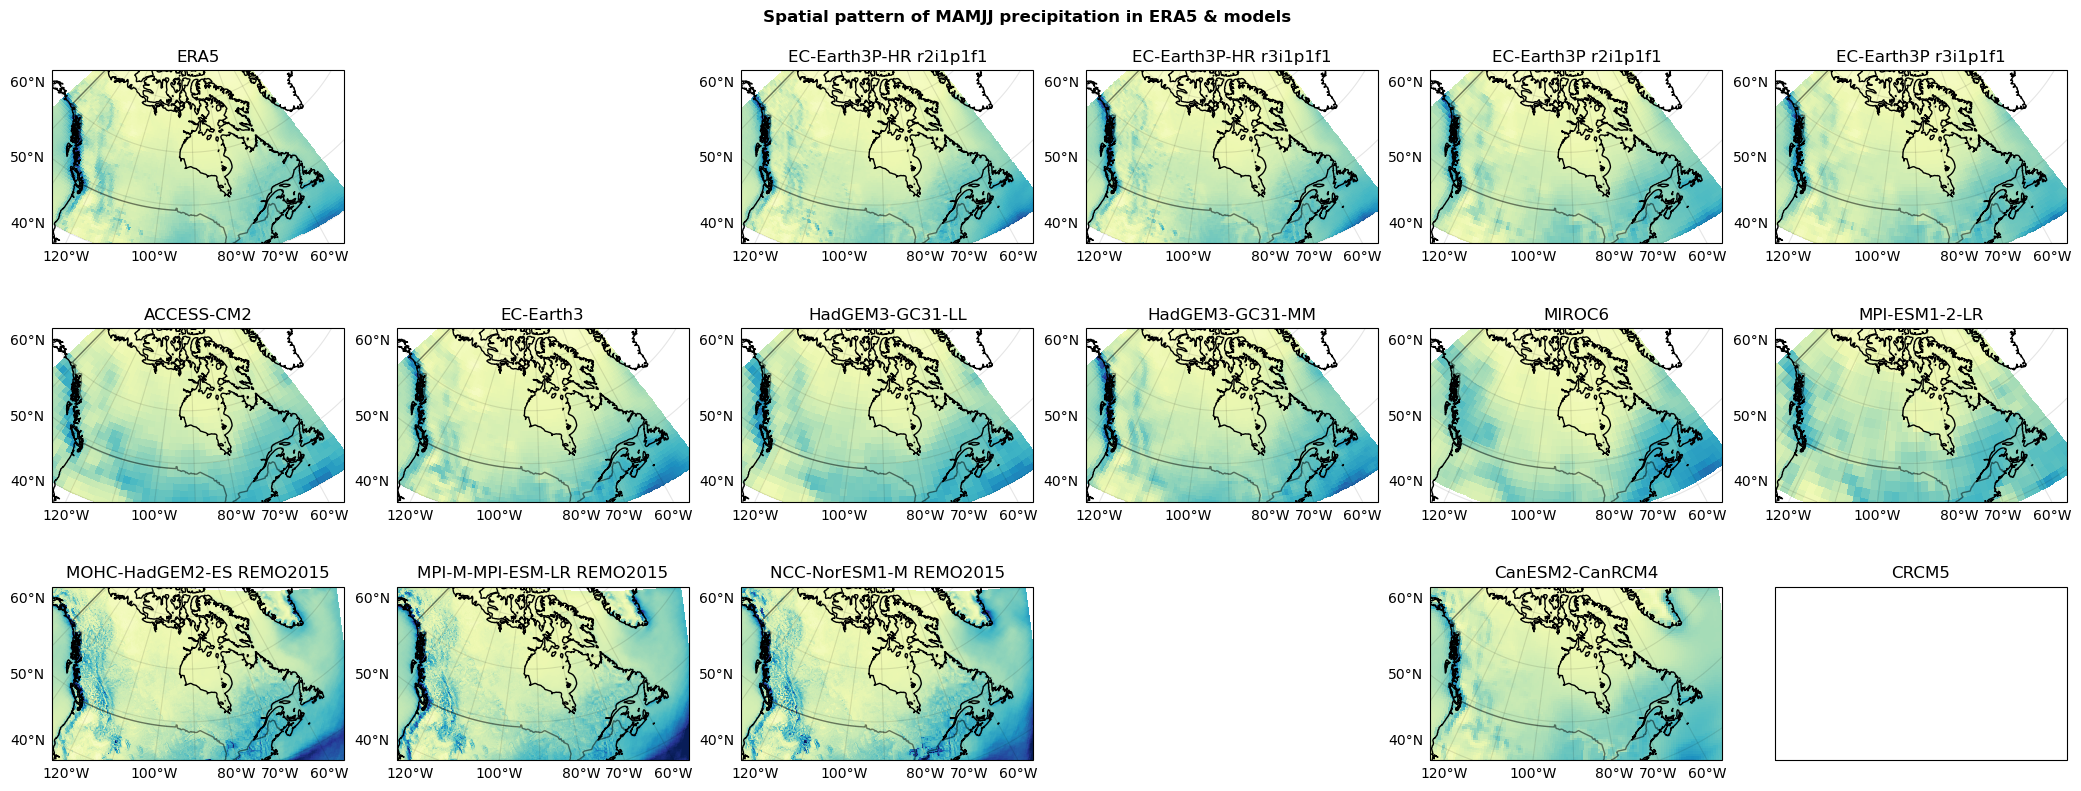

In [9]:
fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (26,10), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.18, hspace = 0.02)
plot_kwargs = { "cmap" : "YlGnBu", "vmin" : 0 , "vmax" : 8}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ERA5
x,y = latlon_to_lambert(era5.rename(lon = "longitude", lat = "latitude"))
axs[0,0].pcolormesh(x,y,era5, **plot_kwargs)
axs[0,0].set_title("ERA5")
overlay_details(axs[0,0])

axs[0,1].set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# highresmip
for i in range(len(highresmip_fl)):
    ax = axs[0,i+2]
    fnm = highresmip_fl[i]
    da = xr.open_dataset(fnm)[varnm]
    da = convert_units_to(da.sel(month = [3,4,5,6,7]).mean("month"), "mm/day")
    x,y = latlon_to_lambert(da.rename(lon = "longitude", lat = "latitude"))
    ax.pcolormesh(x,y,da, **plot_kwargs)
    ax.set_title(fnm.split("_")[2]+" "+fnm.split("_")[4])
    overlay_details(ax)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CMIP6
for i in range(len(cmip6_fl)):
    ax = axs[1,i]
    fnm = cmip6_fl[i]
    da = xr.open_dataset(fnm)[varnm]
    da = convert_units_to(da.sel(month = [3,4,5,6,7]).mean("month"), "mm/day")
    x,y = latlon_to_lambert(da.rename(lon = "longitude", lat = "latitude"))
    ax.pcolormesh(x,y,da, **plot_kwargs)
    ax.set_title(fnm.split("_")[2])
    overlay_details(ax)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# regional models
for i in range(len(cordex_fl)):
    ax = axs[2,i]
    fnm = cordex_fl[i]
    da = xr.open_dataset(fnm)[varnm]
    x,y = latlon_to_lambert(da.rename(lon = "longitude", lat = "latitude"))
    ax.pcolormesh(x,y,da, **plot_kwargs)
    ax.set_title(fnm.split("_")[2]+" REMO2015")
    overlay_details(ax)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
axs[2,3].set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
lens = xr.open_dataset("data/spatial/sp-pr_NAM-44_CCCma-CanESM2_CCCma-CanRCM4_r2.nc").pr
x,y = latlon_to_lambert(lens.rename(lon = "longitude", lat = "latitude"))
axs[2,4].pcolormesh(x,y,lens, **plot_kwargs)
overlay_details(axs[2,4])
axs[2,4].set_title("CanESM2-CanRCM4")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
axs[2,5].set_title("CRCM5")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.suptitle("Spatial pattern of MAMJJ precipitation in ERA5 & models", fontweight = "bold", y = 0.9)
plt.savefig("fig/spatial-pattern-pr.png")

---
---
# **Model data**

## **Compute indices**

In [294]:
sf_ejb = gpd.read_file("sf_ejb").to_crs(epsg = 4326)

fl = glob.glob("cmodel_data/*.nc")
fl = [fnm for fnm in fl if "3P-HR" in fnm]

In [296]:
for fnm in fl:
    
    print(fnm)
    if "highresSST" in fnm:
        mdl = "highresMIP "+fnm.split("_")[2]+"_"+fnm.split("_")[4]
    elif "NAM-22" in fnm:
        mdl = "CORDEX "+fnm.split("_")[3]+"_REMO2015"
    else:
        mdl = "CMIP6 "+fnm.split("_")[2]+"_"+fnm.split("_")[4]
    
    fwi = xr.open_dataset(fnm).fwi
    
    if "latitude" in fwi.dims: fwi.rename(latitude = "lat", longitude = "lon")
    if "rlat" in fwi.dims:
        xydims = ["rlat", "rlon"]
    else:
        xydims = ["lat", "lon"]
    
    rm = regionmask.mask_3D_geopandas(sf_ejb, fwi.lon, fwi.lat).squeeze(drop = True).reset_coords(drop = True)
    fwi = fwi.reset_coords(drop = True)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## FWI7x FOR CLIMATE EXPLORER
    
    # calculate indices & cut off first year
    fwi7x_ts = fwi.rolling(time = 7).mean().resample(time = "AS-JAN").max().isel(time = slice(1, None)).where(rm == 1).mean(xydims).dropna("time", "any")
    fwi7x_ts = fwi7x_ts.assign_coords(time = fwi7x_ts.time.dt.year).rename(time = "year")
    
    # specify filename
    csv_fnm = "ts/canada-wildfires_fwi7x_"+re.sub(" ", "_", mdl)+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+mdl+" fwi7x - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
    str2 = "# fwi7x [] spatial mean of maximum of 7-day average of FWI over Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year fwi7x"

    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    fwi7x_ts.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## cumDSR FOR CLIMATE EXPLORER
    
    # compute DSR, set missing values to zero and mask off study region
    dsr = (fwi ** 1.71) * 0.0272
    dsr = dsr.where(~np.isnan(dsr), 0).where(rm == 1)
    
    cumdsr_ts = dsr.sel(time = [m <= 7 for m in dsr.time.dt.month]).resample(time = "AS-JAN").sum().rename("cumdsr").where(rm == 1).mean(xydims)
    cumdsr_ts = cumdsr_ts.assign_coords(time = cumdsr_ts.time.dt.year).rename(time = "year")
    
    # specify filename
    csv_fnm = "ts/canada-wildfires_cumDSR_"+re.sub(" ", "_", mdl)+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+mdl+" cumulative DSR - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
    str2 = "# cumDSR [] spatial mean of cumulative Daily Severity Rating from Jan-July each year over Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year cumDSR"

    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    cumdsr_ts.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)
    
clear_output(wait = False)
print("Done.")

Done.


## **Copy required GMST time series to study folder**

In [288]:
# GIStemp GMST
gmst = decode_times(xr.open_dataset("data/igiss_al_gl_a_4yrlo(1).nc", decode_times = False)).Ta.sel(time = slice(None, "2023"))
gmst = gmst - gmst.sel(time = "2023").values
gmst = gmst.assign_coords(time = gmst.time.dt.year).rename("gmst", time = "year")

gmst_fnm = "ts/canada-wildfires_gmst-smoothed.dat"

str1 = "# contact :: smoothed GMST - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
str2 = "# gmst [degC] August 2023 snapshot of giss_al_gl_m_4yrlo from KNMI Climate Explorer at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year gmst"

! echo "$str1 " > $gmst_fnm
! echo "$str2" >> $gmst_fnm
! echo "$head" >> $gmst_fnm

gmst.to_dataframe().to_csv(gmst_fnm, sep = " ", mode = "a", header = False)

In [65]:
# CORDEX driving models
for gcm in ["HadGEM", "NorESM", "MPI-ESM-LR", "CanESM2"]:
    gsat_fnm = glob.glob("../10_gsat/cmip5_smoothed-gsat*"+gcm+"*r1.dat")
    if len(gsat_fnm) == 0:
        print("No GSAT:", gcm)
        continue
    
    gsat_fnm = gsat_fnm[0]
    new_fnm = "ts/canada-wildfires_"+gsat_fnm.split("/")[-1]
    if len(new_fnm.split("/")[-1]) > 65: print("Filename too long:", new_fnm)
    ! cp $gsat_fnm $new_fnm

In [274]:
# CMIP6
for mdl in list(set([re.sub(".dat", "","_".join(fnm.split("_")[-2:])) for fnm in glob.glob("ts/*CMIP6*")])):

    gsat_fnm = glob.glob("../10_gsat/cmip6_smoothed-gsat*"+mdl+"_ssp585.dat")
    if len(gsat_fnm) == 0:
        print("No GSAT:", gcm)
        continue
        
    gsat_fnm = gsat_fnm[0]
    new_fnm = re.sub("_ssp585", "", re.sub("_cmip6", "", "ts/canada-wildfires_"+gsat_fnm.split("/")[-1]))
    if len(new_fnm.split("/")[-1]) > 65: print("Filename too long:", new_fnm)
    ! cp $gsat_fnm $new_fnm

ts/canada-wildfires_smoothed-gsat_HadGEM3-GC31-LL_r1i1p1f3.dat
ts/canada-wildfires_smoothed-gsat_EC-Earth3_r1i1p1f1.dat
ts/canada-wildfires_smoothed-gsat_HadGEM3-GC31-MM_r1i1p1f3.dat
ts/canada-wildfires_smoothed-gsat_MPI-ESM1-2-LR_r1i1p1f1.dat
ts/canada-wildfires_smoothed-gsat_MIROC6_r1i1p1f1.dat


# **Compile ensembles for Climate Explorer**

## **CanESM-CanRCM large ensemble**

In [8]:
varnm = "fwi7x"

# load all time series & cat into a single DataArray
ds = xr.concat([pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["time", varnm], index_col = 0).to_xarray().expand_dims(ens = [fnm[-13:-8]]) for fnm in sorted(glob.glob("ts/*"+varnm+"_NAM-44*"))], 
               "ens")[varnm]

# sort out time dimension for Climate Explorer compatibility
y0 = ds.time.min()
ds = ds.assign_coords(time = ds.time - y0)
ds["time"] = ds.time.assign_attrs(standard_name = "time",
                                  units = "years since "+str(y0.values.tolist())+"-1-1 12:00:00",
                                  calendar = "proleptic_gregorian",
                                  axis = "T")

# sort out ensemble index for CX compatibility
ds = ds.assign_coords(ens = [float(v) for v in range(len(ds.ens.values))])
ds["ens"] = ds.ens.assign_attrs(axis = "X")

# reorder dimensions
ds = ds.transpose("time", "ens").copy()
ds.encoding["coordinates"] = "ens time"

# sort out encoding of missing values
ds.encoding["_FillValue"] = -3e+33
ds.encoding["missing_value"] = -3e+33

# and save
ds.to_netcdf("ts/canada-wildfires_"+varnm+"_CanESM2-CanRCM2.nc")

# save as a single dataframe as well, for easier R processing
reduce(lambda  left, right: pd.merge(left,right,left_index = True, right_index = True, how = 'outer'),
       [pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", fnm[-13:-8]],
                    index_col = 0) for fnm in sorted(glob.glob("ts/*"+varnm+"_NAM-44*"))]).to_csv("ts/canada-wildfires_"+varnm+"_CanESM2-CanRCM2.csv")

## **highresMIP**

In [85]:
varnm = "cumDSR"

# load all time series & cat into a single DataArray
ds = xr.concat([pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["time", varnm], 
                            index_col = 0).to_xarray().expand_dims(ens = [fnm[-13:-8]]) for fnm in sorted(glob.glob("ts/*"+varnm+"_highresMIP*"))], 
               "ens")[varnm]

# sort out time dimension for Climate Explorer compatibility
y0 = ds.time.min()
ds = ds.assign_coords(time = ds.time - y0)
ds["time"] = ds.time.assign_attrs(standard_name = "time",
                                  units = "years since "+str(y0.values.tolist())+"-1-1 12:00:00",
                                  calendar = "proleptic_gregorian",
                                  axis = "T")

# sort out ensemble index for CX compatibility
ds = ds.assign_coords(ens = [float(v) for v in range(len(ds.ens.values))])
ds["ens"] = ds.ens.assign_attrs(axis = "X")

# reorder dimensions
ds = ds.transpose("time", "ens").copy()
ds.encoding["coordinates"] = "ens time"

# sort out encoding of missing values
ds.encoding["_FillValue"] = -3e+33
ds.encoding["missing_value"] = -3e+33

# and save
ds.to_netcdf("ts/canada-wildfires_"+varnm+"_highresSST.nc")

# # save as a single dataframe as well, for easier R processing
# reduce(lambda  left, right: pd.merge(left,right,left_index = True, right_index = True, how = 'outer'),
#        [pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", fnm[-13:-8]],
#                     index_col = 0) for fnm in sorted(glob.glob("ts/*"+varnm+"_highresMIP*"))]).to_csv("ts/canada-wildfires_"+varnm+"_highresSST.csv")

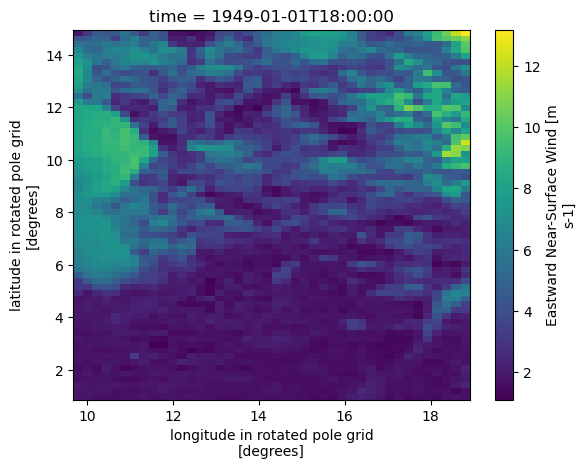

In [88]:
xr.open_dataset("crcm5_wind/var_WS_194901.nc4").isel(time = 0).sfcWind.plot()

# **Synthesis plots**

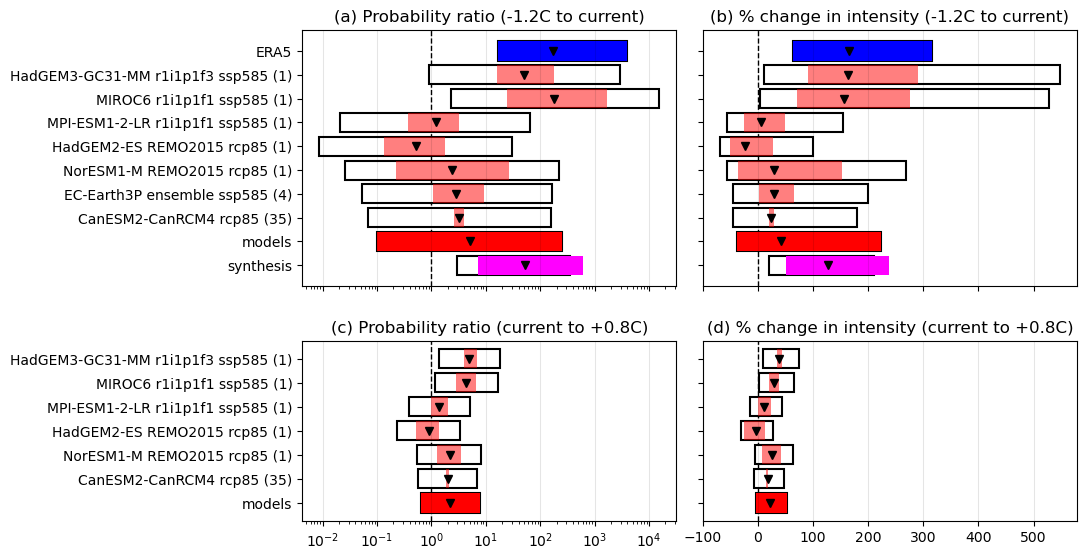

In [3]:
varnm = "cumDSR"

df = {t+"_"+time : pd.read_fwf("synthesis/synth_"+varnm+"-"+t+"_"+time+".txt", skiprows = 4, header = None, widths = [5,5,10,15,12,13,12,2,99], 
                 names = ["y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"], index_col = "model") for time in ["past", "proj"] for t in ["pr", "di"]}

################################################################################################################################################

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (10,(len(df["di_past"]) + len(df["di_proj"])) * 3/8), dpi = 100,
                        sharey = "row", sharex = "col", gridspec_kw = {"height_ratios" : [len(df["pr_past"]), len(df["pr_proj"])]})
plt.subplots_adjust(wspace = 0.07, hspace = 0.25)

pr_ax = axs[:,0]; di_ax = axs[:,1]

gcols = ["blue", "blue", "red", "red", "magenta"]
galpha = [0.5,1,0.5,1,1]

for ax in pr_ax: ax.axvline(1, ls = "--", color = "k", lw = 1, zorder = -99)
for ax in di_ax: ax.axvline(0, ls = "--", color = "k", lw = 1, zorder = -99)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for i in range(2):
    for j in range(2):
        
        ax = axs[i,j]
        ds = ["pr", "di"][j]+"_"+["past", "proj"][i]
        res = df[ds]
        ttl = "("+["a","b","c","d"][i*2+j]+ ") "+["Probability ratio", "% change in intensity"][j]+" "+["(-1.2C to current)", "(current to +0.8C)"][i]
        
        ax.set_title(ttl)
        
        ax.grid(axis = "x", color = "k", alpha = 0.1, ls = "-", zorder = -99)
        
        for k in range(len(res)):
            
            r = res.iloc[k]
            ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "w", lw = 1.5))
            ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, facecolor = gcols[int(r.group)-1], alpha = galpha[int(r.group)-1]))

            ax.plot(r.est, -k, color = "k", marker = "v")  
            
axs[0,0].set_xscale('log') 
# axs[1,0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[0,0].set_yticks(range(0, -len(df["pr_past"]), -1))
axs[0,0].set_yticklabels([re.sub('"', '', r).strip() for r in df["pr_past"].index])

axs[1,0].set_yticks(range(0, -len(df["pr_proj"]), -1))
axs[1,0].set_yticklabels([re.sub('"', '', r).strip() for r in df["pr_proj"].index])

plt.savefig("fig/synthesis_"+varnm+".png")